Psalm Genre Detector

The main task of this project is to use word embeddings to identify genres of biblical Psalms by detecting reoccuring words or topics within each Psalm.

The technical steps of the process are thus:
    - Psalms will be labelled 0-9 according to genre, read from a labelled Bible corpus, and tokenized by word.
    - Initial vector represenations of individual Psalms will be built through a TFIDF matrix, where each row is an individual Psalm and each column is single word in the vocabulary of words appearing across all the Psalms.
    - Word embeddings are created using SVD to create sub-matrices that further define words or topics.
    - For each genre, frequencies of the 10-20 most common words appearing within each Psalm in the genre will be collected, and the word embeddings from these Psalms will be chosen to represent the genre they belong to.
    - Plots of PCA values of groups of Psalms by genre will be used to show the most common words in each genre. The purpose of the plots is to visualize word similarity betwen these common words by how near they are to each other on the plots.
    - Cosine similarity between a genre's most common words and all the other words in the Psalm vocabulary will be computed. The top few most similar words will be analyzed to note any word or topic patterns that may provide insight into how themes across the Psalms are communicated through word use and frequency.

The heart of reflection behind the process is thus:
    - Reflect on most common words appearing in types of Psalms to gain a deeper understanding of themes that the Bible focuses on.
    - Note what word similarities might attest to God's character, human nature, and the relationship we can have with Him.
    - Consider how topic modelling and detecting word relationships through similarity and frequencies can help build Bible study tools such as dictionaries or theme-based concordances.
    - Reflect on how God is the creator of language, poetry, and math, and how He communicates His character through both fluently in ways we will never fully understand but will always be in awe of.

In [ ]:
Part One: 
Labelling, loading, and preprocessing the Psalms.

There are 10 genres that Psalms are labelled as, represented by integers 0 - 9:

- Lament: 0
    - Bringing to God sorrows and requesting for His presence and deliverance.
- Thanksgiving: 1
    - Giving thanks to God for who He is and what He has done.
- Enthronement: 2
    - Ascribing power and glory to God as He exercises His authority as King on the throne.
- Pilgrimage: 3
    - Preparing hearts for an attitude of worship.
- Royal: 4
    - Worshipping God as King of creation, anticipating Christ as King.
- Wisdom: 5
    - Sharing wisdom found through the fear and pursuit of God.
- Imprecatory: 6
    - Requesting God's judgment upon evil and bringing of justice.
- Historical: 7
    - Reflecting on God's faithful guidance of the people of Israel.
- Praise: 8
    - Giving praise to God for who He is and what He has done.
- Confidence: 9
    - Expressing assurance in God's faithfulness, strength, and goodness.

These genres are merely human labels for us to help categorize and remember specific themes that God's Word talks about in each Psalm.

Psalms can be in multiple genres at once, but for simplicity are placed in only one category for this project.

In [15]:
# Importing library modules:

    # NLTK library features for data tokenization:
import nltk
from nltk.tokenize import RegexpTokenizer

    # sklearn library features for vectorizing textual data:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

    # pandas and numpy libraries for array formatting and accessibility:
import pandas as pd
import numpy as np
from collections import Counter

    # matplotlib for plotting data:
from matplotlib import pyplot as plt

    # sklearn function for assessing relatedness between words through cosine similarity:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Loading and preprocessing the Psalms.

    # Open the Psalms corpus, taken from the World Messianic Bible English translation:
with open("./eng-engwmb-psalms.txt", "r") as psalms:
    psalms = psalms.read()

    # Each Psalm is labeled with a beginning "<bn-x>" tag and an ending "<en-x>" tag, 
    # where n == genre label (0 to 9) and x == Psalm chapter number (1 to 150).
    # These tags can be seen as "beginning-of-Psalm" (denoted by the "b" in "<bn-x>") and "end-of-Psalm" (denoted by the "e" in "<en-x>") tags for each Psalm.

    # Set up a tokenizer with a reg-ex expression to separate individual Psalm chapters by the "<bn-x>" and "<en-x>" tags:
chapter_tokenizer = RegexpTokenizer(r'^<b\d+-\d+>.*?<e\d+-\d+>')

    # Tokenize the Psalms by chapter according to the reg-ex detecting "beginning-of-Psalm" and "end-of-Psalm" tags above:
    # This means that one token is one entire Psalm chapter.
psalms_chapters = chapter_tokenizer.tokenize(psalms.lower())


# Source:
    # Fine-tuning the regex expression:
# https://chatgpt.com/share/680dbdf1-d024-8000-9ea4-81e458ab2907

In [3]:
# Display each chapter-tokenized Psalm, without removing tags:

for psalm in psalms_chapters:
    print(psalm)
    print()

<b5-1>
blessed is the man who doesn’t walk in the counsel of the wicked, nor stand on the path of sinners, nor sit in the seat of scoffers;
but his delight is in the lord’s law. on his torah he meditates day and night.
he will be like a tree planted by the streams of water, that produces its fruit in its season, whose leaf also does not wither. whatever he does shall prosper.
the wicked are not so, but are like the chaff which the wind drives away.
therefore the wicked shall not stand in the judgment, nor sinners in the congregation of the righteous.
for the lord knows the way of the righteous, but the way of the wicked shall perish.
<e5-1>

<b4-2>
why do the nations rage, and the peoples plot a vain thing?
the kings of the earth take a stand, and the rulers take counsel together, against the lord, and against his anointed, saying,
“let’s break their bonds apart, and cast their cords from us.”
he who sits in the heavens will laugh. the lord will have them in derision.
then he will spea

In [4]:
# These chapters must be further sub-tokenized by word.
# English "stopwords" are removed for the sake of focusing on main subjects and themes.
# This further tokenization is necessary for representing individual Psalms as vectors, and also for creating individual word embeddings for the entire vocabulary of the Psalms.

# Tokenize each individual Psalm by word:
tokenized_psalms = [ nltk.word_tokenize(psalm.lower()) for psalm in psalms_chapters ]
tokenized_psalms = [ [ word for word in tp if word not in nltk.corpus.stopwords.words("english") ] for tp in tokenized_psalms ]

# Display word-tokenized version of Psalm 1
print(tokenized_psalms[0])

['<', 'b5-1', '>', 'blessed', 'man', '’', 'walk', 'counsel', 'wicked', ',', 'stand', 'path', 'sinners', ',', 'sit', 'seat', 'scoffers', ';', 'delight', 'lord', '’', 'law', '.', 'torah', 'meditates', 'day', 'night', '.', 'like', 'tree', 'planted', 'streams', 'water', ',', 'produces', 'fruit', 'season', ',', 'whose', 'leaf', 'also', 'wither', '.', 'whatever', 'shall', 'prosper', '.', 'wicked', ',', 'like', 'chaff', 'wind', 'drives', 'away', '.', 'therefore', 'wicked', 'shall', 'stand', 'judgment', ',', 'sinners', 'congregation', 'righteous', '.', 'lord', 'knows', 'way', 'righteous', ',', 'way', 'wicked', 'shall', 'perish', '.', '<', 'e5-1', '>']


In [5]:
# String reprentations of Psalms without tags will be generated here.
# These will each be converted into vector format, being constructed together as rows in a TF-IDF matrix.
psalms_no_tags = [ " ".join(map(str, ps[3:-3])) for ps in tokenized_psalms ]

# Display Psalm 1 without tags:
print(psalms_no_tags[0])

blessed man ’ walk counsel wicked , stand path sinners , sit seat scoffers ; delight lord ’ law . torah meditates day night . like tree planted streams water , produces fruit season , whose leaf also wither . whatever shall prosper . wicked , like chaff wind drives away . therefore wicked shall stand judgment , sinners congregation righteous . lord knows way righteous , way wicked shall perish .


Part Two:
Create vectors that represent each Psalm using TF-IDF.

A TF-IDF matrix representing the Psalms is created, each row vector representing individual Psalms in their entirety.
- The elements in a row correspond to a column in the matrix representing a word in the vocabulary of words that appear across tokenized Psalms. 
- An element at index (row, column) is a number representing individual document (row) to word (column) relationship.

In [ ]:
# TF-IDF represenation.
# Set up the vectorizer and use it to transform the textual data into numerical format representing relationships between Psalms and the words appearing in each of them:
vectorizer = TfidfVectorizer()
all_x = vectorizer.fit_transform(psalms_no_tags)

# Put all the vectorized data into TF-IDF matrix form for readability.
# Each row is a Psalm, each column a word in the vocabulary of words appearing across all Psalms.
matrix_psalms = all_x.toarray()

In [ ]:
    # Create and display a dataframe for visualizing the TF-IDF matrix:
psalms_df = pd.DataFrame(matrix_psalms, index=psalms_no_tags, columns=vectorizer.get_feature_names_out())
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

print(psalms_df)

                                                          90        91  \
blessed man ’ walk counsel wicked , stand path ...  0.000000  0.000000   
nations rage , peoples plot vain thing ? kings ...  0.000000  0.000000   
lord , adversaries increased ! many rise . many...  0.000000  0.000000   
answer call , god righteousness . give relief d...  0.000000  0.000000   
give ear words , lord . consider meditation . l...  0.000000  0.000000   
lord , ’ rebuke anger , neither discipline wrat...  0.000000  0.000000   
lord , god , take refuge . save pursue , delive...  0.000000  0.000000   
lord , lord , majestic name earth ! set glory h...  0.000000  0.000000   
give thanks lord whole heart . tell marvelous w...  0.000000  0.000000   
stand far , lord ? hide times trouble ? arrogan...  0.000000  0.000000   
lord , take refuge . say soul , “ flee bird mou...  0.000000  0.000000   
help , lord ; godly man ceases . faithful fail ...  0.000000  0.000000   
long , lord ? forget forever ? long hi

Part Three:
Create word embeddings of each word appearing in a generalized vocabulary of the Psalms using SVD.
Create dictionaries that store Psalms and their TI-IDF and SVD vector representations.

This part continues the vectorization task started in Part Two, taking the TF-IDF matrix representing the collective Psalms and now zooming in representing vocabulary words that appear across all Psalms.

Embeddings generated will numerically represent each individual word that appears in the vocabulary of the tokenized Psalms.

Word embeddings are made with SVD, which is helpful for numerically representing topics as they are used in a corpus.

A dictionary will be created of vocabulary word-vector mappings for easy access.

Another dictionary for Psalm-vector mmappings will also be created.
The values for this dictionary map a Psalm to its TIF-IDF vector and also a list of the appropriate SVD word embeddings in place of the initial word tokens.

In [ ]:
# Create vectors for each word in the Psalms corpus using SVD.

svd = TruncatedSVD(n_components=2)

    # Transpose the TF-IDF matrix so that it can be read by the SVD function. It should read words as rows and documents as columns to make vectors for each word.
psalms_transposed = np.transpose(matrix_psalms)

    # SVD outputs 1D matrix "word_vectors" representing relationships between words. Each element is a vector of 2 components representing each word.
word_vectors = svd.fit_transform(psalms_transposed) 

    # Vocabulary of words appearing cross all tokenized Psalms and their frequency in the tokenized corpus:
vocabulary = vectorizer.get_feature_names_out()

    # Display each word in the vocabulary and their word count:
# print(vectorizer.vocabulary_)

# Sources:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# https://stackoverflow.com/questions/73513808/how-can-i-do-the-transpose-of-a-matrix-in-python
# https://numpy.org/doc/stable/reference/generated/numpy.transpose.html

In [17]:
# A dictionary is built to store word-vector mappings for accessibility.
# Words are the feature name strings as defined by the vectorizer, and the vectors are the embeddings representing each word created by SVD.

    # Dictionary of word-vector mappings:
psalms_vocab_map = dict(zip(vocabulary, word_vectors))

    # Display word-vector mappings:
print("Word-vector mappings:")
for word_vec_pair in list(psalms_vocab_map.items()):
    print(f"{word_vec_pair[0]}:", word_vec_pair[1])

# Source:
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/

Word-vector mappings:
90: [ 0.00703315 -0.00472753]
91: [ 0.00703315 -0.00472753]
aaron: [0.0681271  0.05541629]
abandon: [0.01272762 0.00234655]
abandoned: [ 0.00414733 -0.00383282]
abhor: [ 0.01391421 -0.01158073]
abhorred: [ 0.01630203 -0.00398217]
abhors: [ 0.01946413 -0.00202202]
abiram: [0.00610188 0.00225223]
able: [ 0.02757431 -0.0158723 ]
abominable: [ 0.02771003 -0.03546502]
abomination: [ 0.0085599  -0.00225168]
abraham: [ 0.02772463 -0.00352846]
abroad: [ 0.0153208  -0.00594031]
abundance: [ 0.07083086 -0.04857186]
abundant: [0.04788947 0.04195071]
abundantly: [ 0.02227589 -0.01246011]
abuse: [ 0.00759116 -0.01086705]
abuses: [ 0.00640425 -0.00873753]
accept: [ 0.01436989 -0.00397359]
acceptable: [ 0.01330874 -0.00306996]
accepts: [0.0140668  0.00717746]
acclaim: [0.00690916 0.00218311]
accomplishes: [ 0.01170061 -0.01195546]
according: [ 0.13427348 -0.00695543]
account: [ 0.00673826 -0.00528449]
accuse: [0.01737315 0.00630432]
accusers: [ 0.00988007 -0.00985068]
acknowledg

In [ ]:
# This function takes in a word-tokenized Psalm and outputs a list of word embeddings representing the Psalm.
# Each word token is replaced by its corresponding SVD-generated word embedding from psalms_vocab_map.

def psalm_to_vec(psalm):
        # Get the vectors that are mapped to each individual word appearing in a Psalm:
    psalm_word_vectors = [ psalms_vocab_map[word] for word in psalm if word in list(psalms_vocab_map.keys()) ]
    # print(psalm_word_vectors)
    return psalm_word_vectors


In [ ]:
# Example of psalm_to_vec() output:

print("Word-tokenized Psalm 1:")
print(tokenized_psalms[0])
print()
print("Word embeddings of each token in the word-tokenized Psalm 1:\n(not including beginning/ending of Psalm tags)")
print(psalm_to_vec(tokenized_psalms[0]))

Word-tokenized Psalm 1:
['<', 'b5-1', '>', 'blessed', 'man', '’', 'walk', 'counsel', 'wicked', ',', 'stand', 'path', 'sinners', ',', 'sit', 'seat', 'scoffers', ';', 'delight', 'lord', '’', 'law', '.', 'torah', 'meditates', 'day', 'night', '.', 'like', 'tree', 'planted', 'streams', 'water', ',', 'produces', 'fruit', 'season', ',', 'whose', 'leaf', 'also', 'wither', '.', 'whatever', 'shall', 'prosper', '.', 'wicked', ',', 'like', 'chaff', 'wind', 'drives', 'away', '.', 'therefore', 'wicked', 'shall', 'stand', 'judgment', ',', 'sinners', 'congregation', 'righteous', '.', 'lord', 'knows', 'way', 'righteous', ',', 'way', 'wicked', 'shall', 'perish', '.', '<', 'e5-1', '>']

Word embeddings of each token in the word-tokenized Psalm 1:
(not including beginning/ending of Psalm tags)
[array([0.20546969, 0.05474023]), array([ 0.2957361 , -0.04416206]), array([0.12282201, 0.00471102]), array([0.0867039 , 0.00312994]), array([ 0.32178628, -0.07188527]), array([0.16049425, 0.07617531]), array([ 0.05

Part Four:
Analyze what words may be representative of a genre.

By detecting the frequency of the most common words appearing in each Psalm within a given genre, perhaps we can find what words may be representative of a genre.

A dictionary for accessing and analyzing words in the Psalms that a genre is associated with will be created.

Then, the most common words in the Psalms of each genre will be collected. These words and their frequencies as (word, frequency) tuples will be stored and printed.

In the next part, these words will have their relatedness levels visualized and analyzed.

In [ ]:
# The code creates a dictionary that assigns each Psalm tokens and word embeddings to a genre.
# This will be helpful for accessing and analyzing the words in the Psalms that the genre is associated with.

psalm_genre_dict = {}

    # Loop through each genre label of 0 to 9:
        # - Assign genre labels as keys in psalm_genre_dict
        # - Map values of Psalm tokens and emebdding variations to the keys.

for i in range(10):
    # Key == i == genre    # Value == ( Psalm tokens without tags, TFIDF Psalm representation, word embeddings Psalm representation, Psalm chapter number )
    psalm_genre_dict[i] = [ ( [ word for word in tp if word.isalnum() ], matrix_psalms[tokenized_psalms.index(tp)], psalm_to_vec(tp), int(tp[1][3]) ) for tp in tokenized_psalms if int(tp[1][1]) == i ]

In [ ]:
# Display the lament Psalms and their tokenized, TFIDF, and word embedding representations:
# ( Key 0 == lament )
print(psalm_genre_dict[0])

[(['lord', 'adversaries', 'increased', 'many', 'rise', 'many', 'say', 'soul', 'help', 'selah', 'lord', 'shield', 'around', 'glory', 'one', 'lifts', 'head', 'cry', 'lord', 'voice', 'answers', 'holy', 'hill', 'selah', 'laid', 'slept', 'awakened', 'lord', 'sustains', 'afraid', 'tens', 'thousands', 'people', 'set', 'every', 'side', 'arise', 'lord', 'save', 'god', 'struck', 'enemies', 'cheek', 'bone', 'broken', 'teeth', 'wicked', 'salvation', 'belongs', 'lord', 'may', 'blessing', 'people', 'selah'], array([0., 0., 0., ..., 0., 0., 0.]), [array([1.75259447, 0.87493033]), array([ 0.13840512, -0.03684304]), array([ 0.03790226, -0.00916955]), array([ 0.15039845, -0.00797858]), array([ 0.13388318, -0.03594609]), array([ 0.15039845, -0.00797858]), array([ 0.17494877, -0.04220712]), array([ 0.44744749, -0.08167767]), array([ 0.22534787, -0.05628613]), array([ 0.32783391, -0.21077859]), array([1.75259447, 0.87493033]), array([0.12661188, 0.00780358]), array([ 0.12123182, -0.04984826]), array([0.250

In [ ]:
# Legend for navigating the psalm_genre_dict, using Lament Psalms (Dictionary key 0) as an example and showing dictionary values associated to this genre.

print("Psalm genre:", "Label/Key 0, psalm_genre_dict[0] => Lament")
print("Psalm tokens:","psalm_genre_dict[0][0][0] =>", psalm_genre_dict[0][0][0])
print("Psalm TFIDF:", "psalm_genre_dict[0][0][1] =>", psalm_genre_dict[0][0][1])
print("Psalm vector:", "psalm_genre_dict[0][0][2] =>", psalm_genre_dict[0][0][2])
print("Psalm chapter:", "psalm_genre_dict[0][0][2] =>", psalm_genre_dict[0][0][3])

Psalm genre: Label/Key 0, psalm_genre_dict[0] => Lament
Psalm tokens: psalm_genre_dict[0][0][0] => ['lord', 'adversaries', 'increased', 'many', 'rise', 'many', 'say', 'soul', 'help', 'selah', 'lord', 'shield', 'around', 'glory', 'one', 'lifts', 'head', 'cry', 'lord', 'voice', 'answers', 'holy', 'hill', 'selah', 'laid', 'slept', 'awakened', 'lord', 'sustains', 'afraid', 'tens', 'thousands', 'people', 'set', 'every', 'side', 'arise', 'lord', 'save', 'god', 'struck', 'enemies', 'cheek', 'bone', 'broken', 'teeth', 'wicked', 'salvation', 'belongs', 'lord', 'may', 'blessing', 'people', 'selah']
Psalm TFIDF: psalm_genre_dict[0][0][1] => [0. 0. 0. ... 0. 0. 0.]
Psalm vector: psalm_genre_dict[0][0][2] => [array([1.75259447, 0.87493033]), array([ 0.13840512, -0.03684304]), array([ 0.03790226, -0.00916955]), array([ 0.15039845, -0.00797858]), array([ 0.13388318, -0.03594609]), array([ 0.15039845, -0.00797858]), array([ 0.17494877, -0.04220712]), array([ 0.44744749, -0.08167767]), array([ 0.225347

In [ ]:
# This function:
# - Finds the most common words that appear in a given genre of Psalms.

# It does this by:
# - Taking in parameter "genre", which is an integer from 0-9, representing a Psalm genre.
# - Iterating through the values existing in psalm_genre_dict[genre], which are individual Psalms.
# - Records the frequencies of top 10 words appearing in each individual Psalm, combining these frequencies to be a cumulative score of how many times each word appears in the genre.

def find_genre_most_common_words(genre):
        # Initialize output list, to hold the most common words in the given genre:
    genre_common_words = [ ]

        # Iterate through the Psalms in the given genre:
    for psalm in psalm_genre_dict[genre]:
            # Define the word tokens representing the Psalm:
        tokens = psalm[0]

            # Define the vector representations of the Psalm and its chapter number:
        # tfidf = psalm[1]
        # vector = psalm[2]
        # chapter = psalm[3]

            # Debug:
        # print(tokens)

            # Collect up to 10 most common words appearing in the Psalm:
        chapter_most_common_words = Counter(tokens).most_common(10)

            # Debug:
        # print(chapter_most_common_words)

            # Iterate through the 10 most common words in the Psalm:
        for word in chapter_most_common_words:
                # Debug:
            # print(word)

                # If the current word has not yet been detected as a common word for a previous Psalm:
            if word[0] not in [ elem[0] for elem in genre_common_words ]:
                    # Add this word to genre_common_words, a list holding the words representative of the Psalm genre.
                genre_common_words.append(word)

                # If the current has been detected as a most common word for a previous Psalm:
                    # - This means that multiple Psalms have this word as a top 10 most common word.
                    # - My goal is to to find the "global" frequency of this word by counting how many times is appears in the genre, not needing to store "local" word frequencies or how many times the word appears in one given Psalm.
                    # - So, the current count for how many times the word has appeared in the genre so far will be incremented by the current Psalm holds the word being examined.
            else:
                    # Get the index of where the word being examined appears already in genre_common_words:
                current_word_idx = genre_common_words.index([ item for item in genre_common_words  if item[0] == word[0] ][0])
                    # Increment the current word count at the appropriate index:
                current_word_count = genre_common_words[current_word_idx][1]

                    # Debug, see if the word count is being updated properly:
                # print(current_word_count, "+", word[1])
                # print(current_word_idx)
                    
                    # Update the word count:
                genre_common_words [ current_word_idx ] = ( word[0], current_word_count + word[1])
        
        # print(genre_common_words )
        # print()

        # Final output:
    genre_common_words  = sorted(genre_common_words , key=lambda x:(-x[1], x[0])) 
    return genre_common_words

# Sources:
# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
# https://stackoverflow.com/questions/70314727/how-can-i-sort-a-list-by-the-second-item-descending-and-first-one-ascending

In [162]:
# This function prints out the most common words appearing in a genre, along with each word's word count across all Psalms in the genre.

def display_genre_most_common_words(i):
    most_common = find_genre_most_common_words(i)
    for word, count in most_common: print(f"{word}: {count}")

The following cells will find the most common words of each genre using the display_genre_most_common_words() and  find_genre_most_common_words() functions above.

In [ ]:
lament_most_common = find_genre_most_common_words(0)

print("Lament Psalms, most common words:\n")
for word, count in lament_most_common: print(f"{word}: {count}")

Lament Psalms, most common words:

lord: 187
god: 145
us: 56
shall: 45
let: 43
soul: 42
like: 31
name: 20
day: 19
praise: 17
heart: 16
hand: 14
among: 13
man: 13
face: 12
long: 12
people: 12
righteousness: 12
days: 11
hear: 11
help: 11
selah: 11
wicked: 11
away: 10
earth: 10
men: 10
remember: 10
kindness: 9
lips: 9
loving: 9
may: 9
one: 9
prayer: 9
refuge: 9
spirit: 9
voice: 9
evil: 8
mouth: 8
also: 7
forever: 7
hands: 7
seek: 7
turn: 7
call: 6
disappointed: 6
eyes: 6
heavens: 6
iniquity: 6
israel: 6
neither: 6
put: 6
servant: 6
tongue: 6
within: 6
according: 5
adversaries: 5
come: 5
cry: 5
enemy: 5
far: 5
give: 5
helpless: 5
land: 5
make: 5
mercy: 5
place: 5
salvation: 5
sin: 5
sing: 5
wake: 5
years: 5
ask: 4
broken: 4
cried: 4
deliver: 4
eat: 4
edom: 4
fear: 4
good: 4
hosts: 4
keep: 4
mine: 4
morning: 4
night: 4
shine: 4
surely: 4
take: 4
trusted: 4
yes: 4
afraid: 3
always: 3
anger: 3
answer: 3
burnt: 3
cause: 3
despair: 3
dwelling: 3
ear: 3
every: 3
glory: 3
judge: 3
lest: 3
mother:

In [74]:
thanksgiving_most_common = find_genre_most_common_words(1)

print("Thanksgiving Psalms, most common words:\n")
for word, count in thanksgiving_most_common: print(f"{word}: {count}")

Thanksgiving Psalms, most common words:

lord: 220
praise: 70
loving: 50
kindness: 49
forever: 41
endures: 33
god: 27
earth: 24
let: 23
name: 21
shall: 15
sing: 15
soul: 13
give: 12
thanks: 12
fear: 11
heavens: 8
israel: 8
like: 8
nations: 8
us: 8
evil: 7
people: 7
blessed: 6
children: 6
come: 6
deeds: 6
good: 6
iniquity: 6
made: 6
mountains: 6
selah: 6
trouble: 6
high: 5
house: 5
live: 5
wicked: 5
word: 5
day: 4
great: 4
makes: 4
man: 4
righteous: 4
servants: 4
surrounded: 4
wonderful: 4
works: 4
also: 3
away: 3
call: 3
death: 3
delivers: 3
joy: 3
judgment: 3
lack: 3
may: 3
offer: 3
oh: 3
praises: 3
servant: 3
sin: 3
waters: 3
whose: 3
yes: 3
acts: 2
amen: 2
army: 2
clothed: 2
covenant: 2
creatures: 2
cried: 2
cymbals: 2
done: 2
egypt: 2
end: 2
enemies: 2
everlasting: 2
eyes: 2
glory: 2
go: 2
grain: 2
hand: 2
heart: 2
help: 2
hidden: 2
holy: 2
jerusalem: 2
make: 2
men: 2
mercy: 2
night: 2
overflow: 2
pit: 2
princes: 2
rejoice: 2
rejoicing: 2
righteousness: 2
roaring: 2
said: 2
sins: 2

In [75]:
enthronement_most_common = find_genre_most_common_words(2)

print("Enthronement Psalms, most common words:\n")
for word, count in enthronement_most_common: print(f"{word}: {count}")

Enthronement Psalms, most common words:

lord: 38
sing: 15
earth: 14
let: 14
god: 13
peoples: 8
among: 6
holy: 6
nations: 6
praises: 5
righteousness: 4
ascribe: 3
floods: 3
glad: 3
glory: 3
judge: 3
king: 3
salvation: 3
established: 2
exalt: 2
gods: 2
great: 2
joy: 2
joyful: 2
justice: 2
lifted: 2
make: 2
mighty: 2
name: 2
noise: 2
presence: 2
reigns: 2
righteous: 2
shout: 2
us: 2
armed: 1
clothed: 1
majesty: 1
strength: 1


In [76]:
pilgrimage_most_common = find_genre_most_common_words(3)

print("Pilgrimage Psalms, most common words:\n")
for word, count in pilgrimage_most_common: print(f"{word}: {count}")

Pilgrimage Psalms, most common words:

lord: 51
god: 35
earth: 9
selah: 9
let: 8
house: 7
like: 6
zion: 6
blessed: 5
children: 5
soul: 5
us: 5
city: 4
feared: 4
forever: 4
go: 4
great: 4
help: 4
hosts: 4
one: 4
praise: 4
though: 4
within: 4
would: 4
born: 3
good: 3
jerusalem: 3
keep: 3
may: 3
mount: 3
mountains: 3
moved: 3
peace: 3
refuge: 3
see: 3
strength: 3
vain: 3
afflicted: 2
away: 2
beard: 2
carrying: 2
child: 2
courts: 2
done: 2
dwell: 2
escaped: 2
even: 2
eyes: 2
fears: 2
gone: 2
joy: 2
judgment: 2
keeps: 2
lift: 2
man: 2
many: 2
men: 2
nations: 2
oh: 2
righteous: 2
say: 2
side: 2
sleep: 2
slumber: 2
snare: 2
things: 2
thrones: 2
times: 2
tribes: 2
unless: 2
war: 2
waters: 2
weaned: 2
wrath: 2
yes: 2
youth: 2
arrogant: 1
back: 1
brothers: 1
brought: 1
build: 1
builds: 1
cause: 1
come: 1
comes: 1
concern: 1
eat: 1
everyone: 1
foundation: 1
gates: 1
glad: 1
greatly: 1
hands: 1
heart: 1
hills: 1
holy: 1
israel: 1
judah: 1
labor: 1
live: 1
lofty: 1
look: 1
loves: 1
nation: 1
night:

In [77]:
royal_most_common = find_genre_most_common_words(4)
print("Royal Psalms, most common words:\n")
for word, count in royal_most_common: print(f"{word}: {count}")

Royal Psalms, most common words:

lord: 59
shall: 27
god: 21
hand: 15
like: 15
forever: 14
also: 13
one: 8
faithfulness: 7
king: 7
earth: 6
enemies: 6
exalted: 6
loving: 6
people: 6
right: 6
came: 5
feet: 5
kindness: 5
made: 5
make: 5
whose: 5
david: 4
heart: 4
high: 4
may: 4
needy: 4
place: 4
poor: 4
rock: 4
answer: 3
bring: 3
day: 3
eyes: 3
grant: 3
hands: 3
long: 3
man: 3
name: 3
righteousness: 3
take: 3
therefore: 3
among: 2
anointed: 2
away: 2
blameless: 2
break: 2
crush: 2
dwell: 2
dwelling: 2
find: 2
give: 2
go: 2
house: 2
kings: 2
land: 2
let: 2
majesty: 2
mighty: 2
morning: 2
nations: 2
priests: 2
rejoices: 2
rescue: 2
resting: 2
salvation: 2
set: 2
sing: 2
son: 2
sons: 2
strength: 2
trust: 2
within: 2
wrath: 2
says: 1
sit: 1
trouble: 1


In [78]:
wisdom_most_common = find_genre_most_common_words(5)

print("Wisdom Psalms, most common words:\n")
for word, count in wisdom_most_common: print(f"{word}: {count}")

Wisdom Psalms, most common words:

lord: 45
statutes: 33
word: 32
shall: 30
torah: 24
commandments: 22
heart: 22
precepts: 21
wicked: 20
according: 19
let: 19
ordinances: 15
righteous: 12
like: 11
man: 10
god: 8
cut: 6
land: 6
way: 6
forever: 5
inherit: 5
behold: 3
blessed: 3
perish: 3
sheol: 3
surely: 3
afraid: 2
endures: 2
good: 2
men: 2
plagued: 2
redeem: 2
rich: 2
righteousness: 2
sinners: 2
stand: 2
strength: 2
understanding: 2
upright: 2
wealth: 2


In [80]:
imprecatory_most_common = find_genre_most_common_words(6)

print("Imprecatory Psalms, most common words:\n")
for word, count in imprecatory_most_common: print(f"{word}: {count}")

Imprecatory Psalms, most common words:

let: 83
god: 82
lord: 61
shall: 12
like: 11
us: 10
sing: 9
soul: 9
strength: 7
also: 6
forever: 6
hand: 6
kindness: 6
among: 5
answer: 5
behold: 5
come: 5
jerusalem: 5
know: 5
reproach: 5
would: 5
cause: 4
deep: 4
deliver: 4
high: 4
israel: 4
mountains: 4
nations: 4
princes: 4
say: 4
waters: 4
yes: 4
adversaries: 3
away: 3
become: 3
children: 3
contend: 3
darkness: 3
destruction: 3
hate: 3
mouth: 3
name: 3
offering: 3
rejoice: 3
righteous: 3
songs: 3
thoughts: 3
tower: 3
within: 3
without: 3
babylon: 2
break: 2
bring: 2
brought: 2
could: 2
death: 2
declared: 2
enemies: 2
enemy: 2
forget: 2
good: 2
heart: 2
holy: 2
iniquity: 2
joy: 2
judgment: 2
land: 2
love: 2
loving: 2
man: 2
many: 2
men: 2
poison: 2
pursue: 2
search: 2
selah: 2
servants: 2
teeth: 2
tongue: 2
trust: 2
turned: 2
voice: 2
wicked: 2
zion: 2


In [185]:
historical_most_common = find_genre_most_common_words(7)

print("Historical Psalms, most common words:\n")
for word, count in historical_most_common: print(f"{word}: {count}")

Historical Psalms, most common words:

god: 27
lord: 21
also: 16
people: 14
israel: 11
land: 10
like: 8
gave: 7
would: 7
anger: 6
let: 6
children: 5
praise: 5
turned: 5
fathers: 4
hand: 4
made: 4
nations: 4
sea: 4
sent: 4
word: 4
works: 4
among: 3
blessed: 3
come: 3
give: 3
listen: 3
loving: 3
oh: 3
peoples: 3
seek: 3
egypt: 2
great: 2
heart: 2
jacob: 2
moon: 2
shall: 2
shout: 1
sing: 1


In [82]:
praise_most_common = find_genre_most_common_words(8)

print("Praise Psalms, most common words:\n")
for word, count in praise_most_common: print(f"{word}: {count}")

Praise Psalms, most common words:

lord: 51
god: 13
glory: 11
like: 7
praise: 7
voice: 7
works: 7
earth: 6
let: 6
forever: 5
king: 5
lift: 5
name: 5
wicked: 5
enemies: 4
heavens: 4
holy: 4
judge: 4
kingdom: 4
man: 4
acts: 3
ascribe: 3
ever: 3
flourish: 3
great: 3
mine: 3
ones: 3
shall: 3
sing: 3
speak: 3
back: 2
behold: 2
breaks: 2
calls: 2
cedars: 2
covenant: 2
drink: 2
evildoers: 2
execute: 2
fled: 2
gates: 2
give: 2
heads: 2
high: 2
honor: 2
horn: 2
israel: 2
jacob: 2
jordan: 2
lebanon: 2
lifted: 2
majestic: 2
may: 2
mountains: 2
one: 2
people: 2
praises: 2
rams: 2
rejoice: 2
said: 2
sea: 2
seek: 2
selah: 2
silent: 2
skipped: 2
strength: 2
thanks: 2
waters: 2
yes: 2
babes: 1
blamelessly: 1
dwell: 1
hill: 1
lips: 1
live: 1
sanctuary: 1
set: 1
walks: 1


In [ ]:
confidence_most_common = find_genre_most_common_words(9)

print("Confidence Psalms, most common words:\n")
for word, count in confidence_most_common: print(f"{word}, {count}")

Confidence Psalms, most common words:

lord, 25
god, 17
us, 9
bless, 8
shall, 7
soul, 6
let, 5
peoples, 5
alone, 4
earth, 4
praise, 4
salvation, 4
heavens, 3
help, 3
house, 3
nations, 3
righteous, 3
rock, 3
shield, 3
take, 3
trust, 3
wicked, 3
eyes, 2
fortress, 2
good, 2
heart, 2
holy, 2
like, 2
loves, 2
man, 2
may, 2
men, 2
ones, 2
selah, 2
shaken, 2
throw, 2
upright, 2
yes, 2
green, 1
lack, 1
leads, 1
lie, 1
makes, 1
nothing, 1
pastures, 1
refuge, 1
shepherd, 1


Part Five:
Visualize word-relatedness between the 20 most common words of a Psalm genre through PCA value plotting.

PCA takes in the SVD-generated word embeddings and reduces their dimensionality to 2D.
These 2D points are then plotted, so that one can see word-relatedness a little more clearly.

This visualization is done in hopes that words or topics representative of a genre can be understood at a deeper level by seeing a model's perception of relatedness between these words and topics.

In [ ]:
# Define a PCA object for visualing most common words appearing in Psalm genres:
pca_psalms = PCA()

    # This function computes and plots PCA-generated 2D representations of SVD word embeddings.
    # One genre will be examined during a function call.
def plot_genre_pca(genre_most_common, limit1=None, limit2=None):

        # Collecting the embeddings corresponding to the most common words in the Psalm genre being examined:
        # Assign word-vector mappings as dictionary key-value pairs:
    genre_rep_vectors = { k:v for (k, v) in [ ( item[0], psalms_vocab_map[item[0]] )  for item in genre_most_common ] }
    
        # Transform these vectors into 2D through PCA:
    genre_pca = pca_psalms.fit_transform(list(genre_rep_vectors.values())[:20] ) 

        # Set up the pyplot visuals:
    fig, ax = plt.subplots()

        # Set up an option to zoom in on a specific area in the plot if many words are too close to each other.
        # This is a common need for reading plots of small corpuses like an individual Psalm.
    if limit1 != None and limit2 != None:
        plt.xlim(limit1, limit2)
        
        # Scatter the PCA points representing each word vector, where PCA component 0 is the x-values and PCA component 1 is the y-values:
    ax.scatter(genre_pca[:, 0], genre_pca[:, 1])

        # Get the word vectors representing the most common words in the genre:
    word_vectors = list(genre_rep_vectors.keys())[:20]

        # Annotate the word labels on each word vector point:
    for l in word_vectors:
        ax.annotate(l, (genre_pca[word_vectors.index(l)][0], genre_pca[word_vectors.index(l)][1]))
        print(l, ( genre_pca[word_vectors.index(l)][0], genre_pca[word_vectors.index(l)][1] ))
        
# Sources:
# Code modified from what I wrote for PCA visiualization for Homework 3.
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html
# https://machinelearningmastery.com/principal-component-analysis-for-visualization/
# https://stackoverflow.com/questions/14432557/scatter-plot-with-different-text-at-each-data-point
# https://dagshub.com/blog/how-to-train-a-custom-llm-embedding-model/
# https://www.geeksforgeeks.org/python-dictionary-comprehension/

The following cells will plot PCA representations of the most commonly occurring words in each Psalm genre.

Plotting perceived Lament Psalm word-relatedness:

lord (1.564756588529094, 0.08924974087300369)
god (0.1137337503244682, -0.9197640197798616)
us (-0.07724664948241039, -0.20135137064372782)
shall (0.008842082501713866, -0.25138667791000163)
let (0.11392128999294138, -0.3747269824095007)
soul (-0.049192211958864585, -0.02769802080721373)
like (-0.05906432755385416, -0.027539944593493626)
name (0.03495008266626276, 0.16937013089768072)
day (-0.20092169093672865, 0.09908452751528113)
praise (0.47615869309955994, 0.45106740743408147)
heart (-0.13150955009333487, -0.001037714194838335)
hand (-0.15906140129713184, 0.05788257661267718)
among (-0.21000772517266497, 0.08822077975562875)
man (-0.15778408456854914, 0.08469225029845037)
face (-0.2587159838786103, 0.14524208956454757)
long (-0.22722350374764783, 0.10587805745995096)
people (-0.10287328452655531, 0.10623319217524854)
righteousness (-0.16746542666974715, 0.10207573240006204)
days (-0.2760146574874479, 0.17687411715150186)
hear (-0.2

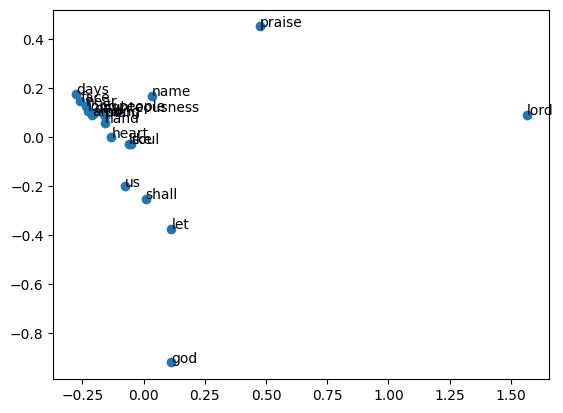

In [163]:
print("Plotting perceived Lament Psalm word-relatedness:\n")
plot_genre_pca(lament_most_common)

Zooming in the graph on perceived Lament Psalm word-relatedness:

lord (1.564756588529094, 0.08924974087300369)
god (0.1137337503244682, -0.9197640197798616)
us (-0.07724664948241039, -0.20135137064372782)
shall (0.008842082501713866, -0.25138667791000163)
let (0.11392128999294138, -0.3747269824095007)
soul (-0.049192211958864585, -0.02769802080721373)
like (-0.05906432755385416, -0.027539944593493626)
name (0.03495008266626276, 0.16937013089768072)
day (-0.20092169093672865, 0.09908452751528113)
praise (0.47615869309955994, 0.45106740743408147)
heart (-0.13150955009333487, -0.001037714194838335)
hand (-0.15906140129713184, 0.05788257661267718)
among (-0.21000772517266497, 0.08822077975562875)
man (-0.15778408456854914, 0.08469225029845037)
face (-0.2587159838786103, 0.14524208956454757)
long (-0.22722350374764783, 0.10587805745995096)
people (-0.10287328452655531, 0.10623319217524854)
righteousness (-0.16746542666974715, 0.10207573240006204)
days (-0.2760146574874479, 0.17687411715150

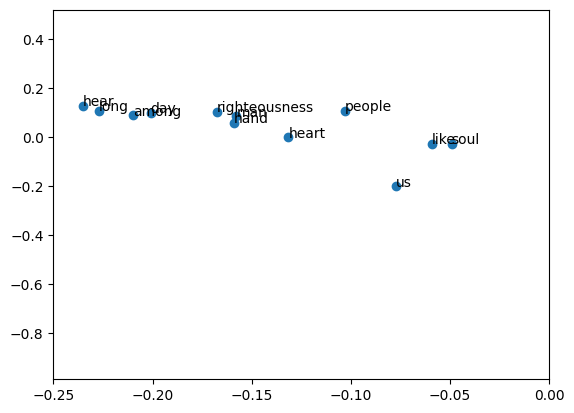

In [165]:
print("Zooming in the graph on perceived Lament Psalm word-relatedness:\n")
plot_genre_pca(lament_most_common, limit1=-0.25, limit2=0)

Plotting perceived Thanksgiving Psalm word-relatedness:

lord (1.495371615036957, 0.09198084532170647)
praise (0.3907737707068265, 0.4015305248087687)
loving (-0.050436980444519885, 0.09421392485563027)
kindness (-0.06445176909876238, 0.08131301731149512)
forever (0.012291114184093455, 0.17732548119304734)
endures (-0.1535319158651674, 0.32763490033595666)
god (0.09406218214704065, -0.9850093679448706)
earth (-0.06601073526785745, -0.008131539369146817)
let (0.06828573605157207, -0.4405821624313373)
name (-0.03651481538753887, 0.09913532358694929)
shall (-0.04254970456286339, -0.3223875108399157)
sing (-0.14271372366123963, 0.005979188776638389)
soul (-0.11117390660914633, -0.10171736436899706)
give (-0.1792653216642669, 0.08479148462541264)
thanks (-0.2299428823040095, 0.1550397221248454)
fear (-0.236721021813077, 0.10180727378338493)
heavens (-0.21704015852630748, 0.18032341119312242)
israel (-0.2389177836578678, 0.08595937925684416)
like (-0.12104234489271853, -0.10202974275093998)


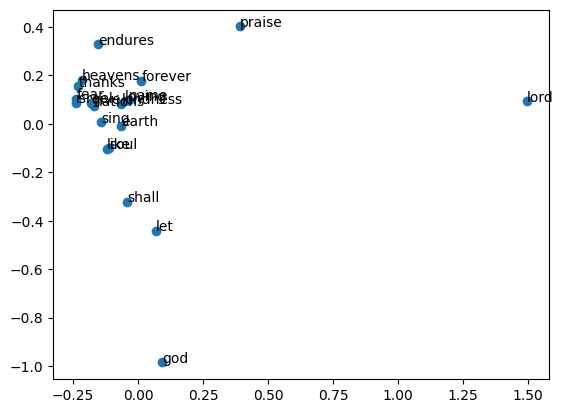

In [166]:
print("Plotting perceived Thanksgiving Psalm word-relatedness:\n")
plot_genre_pca(thanksgiving_most_common)

Zooming in the graph on perceived Thanksgiving Psalm word-relatedness:

lord (1.495371615036957, 0.09198084532170647)
praise (0.3907737707068265, 0.4015305248087687)
loving (-0.050436980444519885, 0.09421392485563027)
kindness (-0.06445176909876238, 0.08131301731149512)
forever (0.012291114184093455, 0.17732548119304734)
endures (-0.1535319158651674, 0.32763490033595666)
god (0.09406218214704065, -0.9850093679448706)
earth (-0.06601073526785745, -0.008131539369146817)
let (0.06828573605157207, -0.4405821624313373)
name (-0.03651481538753887, 0.09913532358694929)
shall (-0.04254970456286339, -0.3223875108399157)
sing (-0.14271372366123963, 0.005979188776638389)
soul (-0.11117390660914633, -0.10171736436899706)
give (-0.1792653216642669, 0.08479148462541264)
thanks (-0.2299428823040095, 0.1550397221248454)
fear (-0.236721021813077, 0.10180727378338493)
heavens (-0.21704015852630748, 0.18032341119312242)
israel (-0.2389177836578678, 0.08595937925684416)
like (-0.12104234489271853, -0.1020

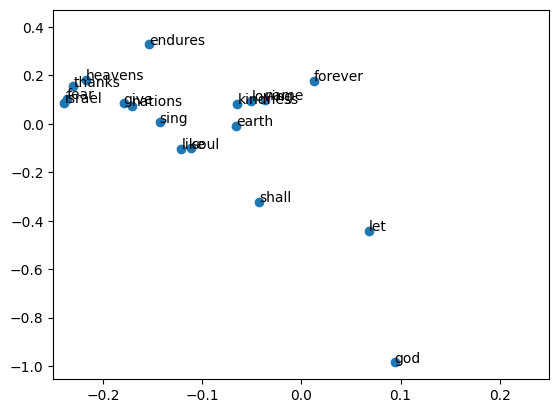

In [187]:
print("Zooming in the graph on perceived Thanksgiving Psalm word-relatedness:\n")
plot_genre_pca(thanksgiving_most_common, limit1=-0.25, limit2=0.25)

Plotting perceived Enthronement Psalm word-relatedness:

lord (1.5744735096552098, 0.4607185520873327)
sing (0.0024506862000261975, -0.007751408873318225)
earth (0.08032185780668616, -0.00344540029393936)
let (0.3124651728514779, -0.3922365587270263)
god (0.4654357581060654, -0.915366951003614)
peoples (-0.10892945485774178, 0.050558007102538535)
among (-0.12849707267401084, -0.038961969517754755)
holy (-0.06414364609483347, 0.0771004581131019)
nations (-0.04023522182827377, 0.05069961817308424)
praises (-0.16585402374318411, 0.030237269797278324)
righteousness (-0.09156190645238044, -0.013711219610645323)
ascribe (-0.2684169979726453, 0.14383168090052964)
floods (-0.2930669845472078, 0.13027721265445946)
glad (-0.19470542111496503, 0.015056297171737842)
glory (-0.08830253351825251, 0.1007421523130157)
judge (-0.20279235061116083, 0.03730191704282184)
king (-0.14953909902522233, 0.055477931825967726)
salvation (-0.12309730310790817, -0.04065372594841725)
established (-0.229240716428226

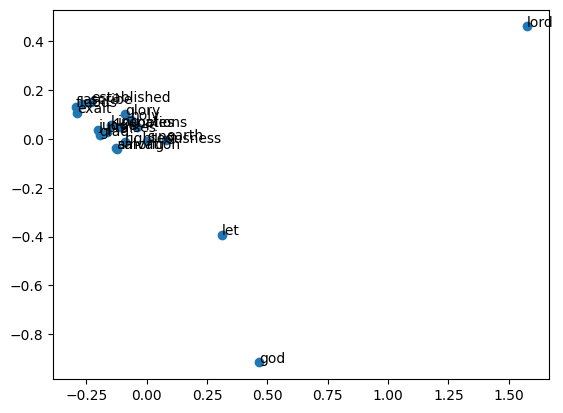

In [168]:
print("Plotting perceived Enthronement Psalm word-relatedness:\n")
plot_genre_pca(enthronement_most_common)

Zooming in the graph on perceived Enthronement Psalm word-relatedness:

lord (1.5744735096552098, 0.4607185520873327)
sing (0.0024506862000261975, -0.007751408873318225)
earth (0.08032185780668616, -0.00344540029393936)
let (0.3124651728514779, -0.3922365587270263)
god (0.4654357581060654, -0.915366951003614)
peoples (-0.10892945485774178, 0.050558007102538535)
among (-0.12849707267401084, -0.038961969517754755)
holy (-0.06414364609483347, 0.0771004581131019)
nations (-0.04023522182827377, 0.05069961817308424)
praises (-0.16585402374318411, 0.030237269797278324)
righteousness (-0.09156190645238044, -0.013711219610645323)
ascribe (-0.2684169979726453, 0.14383168090052964)
floods (-0.2930669845472078, 0.13027721265445946)
glad (-0.19470542111496503, 0.015056297171737842)
glory (-0.08830253351825251, 0.1007421523130157)
judge (-0.20279235061116083, 0.03730191704282184)
king (-0.14953909902522233, 0.055477931825967726)
salvation (-0.12309730310790817, -0.04065372594841725)
established (-0.

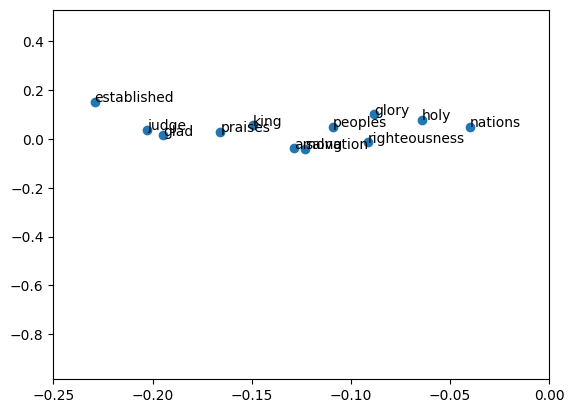

In [188]:
print("Zooming in the graph on perceived Enthronement Psalm word-relatedness:\n")
plot_genre_pca(enthronement_most_common, limit1=-0.25, limit2=0)

Plotting perceived Royal Psalm word-relatedness:

lord (1.5805772270147869, 0.2751165962687815)
shall (0.09691178268232514, -0.30422783423995825)
god (0.30485371394701033, -0.9480373451401712)
hand (-0.11721138726216707, -0.024960364316007233)
like (-0.005105440036435982, -0.09372575156176355)
forever (0.09702098072782694, 0.19848538210029237)
also (-0.13057029491571862, -0.01193522588961135)
one (-0.19306881216732474, -0.06638744561212642)
faithfulness (-0.20228926746968226, 0.16685679511598697)
king (-0.18107571282167229, 0.09340706221928588)
earth (0.03937598999544101, 0.005605779376558956)
enemies (-0.1668559772328798, -0.008130668010489811)
exalted (-0.2437588112815812, 0.09636951076638223)
loving (0.04371443414119763, 0.10903843277516759)
people (-0.06925980805188198, 0.03156867727097945)
right (-0.204501828792051, 0.04719879932489582)
came (-0.3101775730987658, 0.12499874176264712)
feet (-0.26985657276047853, 0.09723599465022911)
kindness (0.03118752529372515, 0.0946883710605782

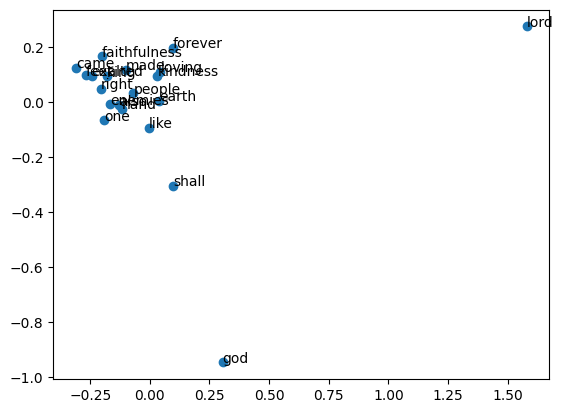

In [170]:
print("Plotting perceived Royal Psalm word-relatedness:\n")
plot_genre_pca(royal_most_common)

Zooming in the graph on perceived Royal Psalm word-relatedness:

lord (1.5805772270147869, 0.2751165962687815)
shall (0.09691178268232514, -0.30422783423995825)
god (0.30485371394701033, -0.9480373451401712)
hand (-0.11721138726216707, -0.024960364316007233)
like (-0.005105440036435982, -0.09372575156176355)
forever (0.09702098072782694, 0.19848538210029237)
also (-0.13057029491571862, -0.01193522588961135)
one (-0.19306881216732474, -0.06638744561212642)
faithfulness (-0.20228926746968226, 0.16685679511598697)
king (-0.18107571282167229, 0.09340706221928588)
earth (0.03937598999544101, 0.005605779376558956)
enemies (-0.1668559772328798, -0.008130668010489811)
exalted (-0.2437588112815812, 0.09636951076638223)
loving (0.04371443414119763, 0.10903843277516759)
people (-0.06925980805188198, 0.03156867727097945)
right (-0.204501828792051, 0.04719879932489582)
came (-0.3101775730987658, 0.12499874176264712)
feet (-0.26985657276047853, 0.09723599465022911)
kindness (0.03118752529372515, 0.0

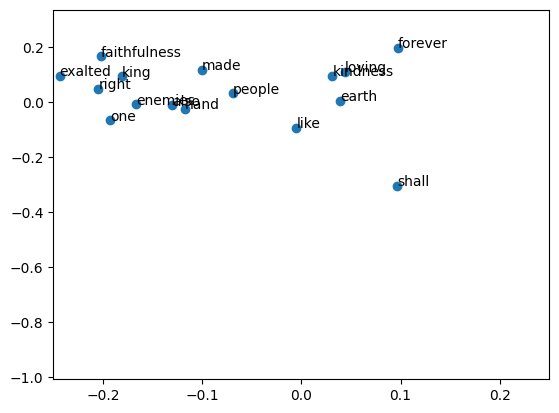

In [189]:
print("Zooming in the graph on perceived Royal Psalm word-relatedness:\n")
plot_genre_pca(royal_most_common, limit1=-0.25, limit2=0.25)

Plotting perceived Pilgrimage Psalm word-relatedness:

lord (1.576594159287981, 0.361842964651404)
god (0.3447710869417266, -0.9055117467903768)
earth (0.04584880820055909, 0.038182643425399176)
selah (-0.14344588151676008, -0.13832578810613752)
let (0.24095236158218641, -0.37045373167303663)
house (-0.11407638392168012, 0.22851128528042386)
like (0.004895777213211883, -0.06265484915142502)
zion (-0.1692195906674684, 0.14567459710953642)
blessed (-0.1620475684887664, 0.15343990721820097)
children (-0.13711682201033748, 0.14962559848130677)
soul (0.014616660934984815, -0.06092624448929135)
us (0.020213877293643767, -0.2367420814984744)
city (-0.3021152659880168, 0.06556606124624932)
feared (-0.32226289265564995, 0.16034473937885843)
forever (0.09666028450987574, 0.232974018949753)
go (-0.22738274783420023, 0.02569045650918103)
great (-0.09291459951785946, 0.14690765355274632)
help (-0.18346085271792092, 0.04269937684829567)
hosts (-0.3065960947316227, 0.06511310515006395)
one (-0.183914

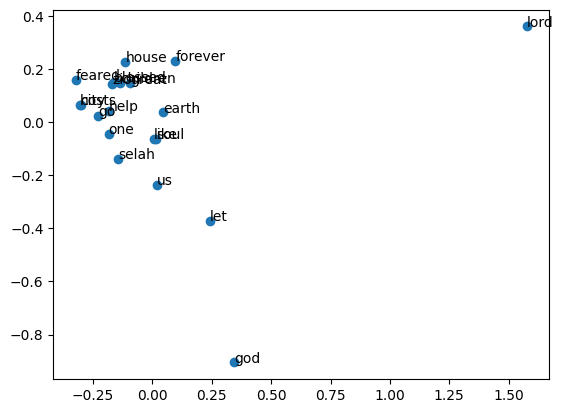

In [173]:
print("Plotting perceived Pilgrimage Psalm word-relatedness:\n")
plot_genre_pca(pilgrimage_most_common)

Zooming in the graph on perceived Pilgrimage Psalm word-relatedness:

lord (1.576594159287981, 0.361842964651404)
god (0.3447710869417266, -0.9055117467903768)
earth (0.04584880820055909, 0.038182643425399176)
selah (-0.14344588151676008, -0.13832578810613752)
let (0.24095236158218641, -0.37045373167303663)
house (-0.11407638392168012, 0.22851128528042386)
like (0.004895777213211883, -0.06265484915142502)
zion (-0.1692195906674684, 0.14567459710953642)
blessed (-0.1620475684887664, 0.15343990721820097)
children (-0.13711682201033748, 0.14962559848130677)
soul (0.014616660934984815, -0.06092624448929135)
us (0.020213877293643767, -0.2367420814984744)
city (-0.3021152659880168, 0.06556606124624932)
feared (-0.32226289265564995, 0.16034473937885843)
forever (0.09666028450987574, 0.232974018949753)
go (-0.22738274783420023, 0.02569045650918103)
great (-0.09291459951785946, 0.14690765355274632)
help (-0.18346085271792092, 0.04269937684829567)
hosts (-0.3065960947316227, 0.06511310515006395)

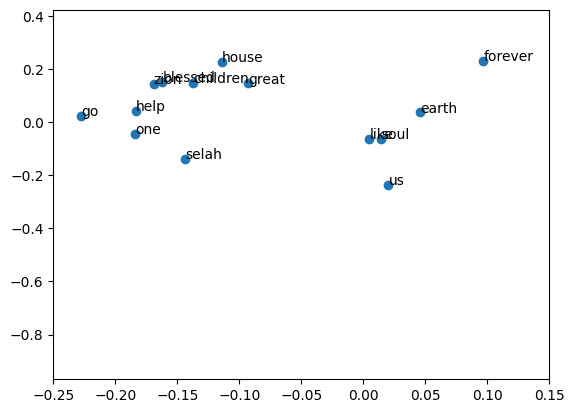

In [174]:
print("Zooming in the graph on perceived Pilgrimage Psalm word-relatedness:\n")
plot_genre_pca(pilgrimage_most_common, limit1=-0.25, limit2=0.15)

Plotting perceived Wisdom Psalm word-relatedness:

lord (1.5627865263412792, 0.5228434136969938)
statutes (-0.2829647483318284, 0.11666650770016354)
word (-0.1831905028699972, 0.14330771493978833)
shall (0.18454551001231922, -0.27550163750345824)
torah (-0.2965845036783573, 0.09536899808510288)
commandments (-0.3083838923301426, 0.11113164005150601)
heart (-0.025387845311311164, -0.07979478854840993)
precepts (-0.29388806622785024, 0.14133819888338836)
wicked (-0.058166154251448, -0.039459217834751675)
according (-0.22371211379481715, 0.06995499191772167)
let (0.3221986153144848, -0.3609773250507632)
ordinances (-0.3016672641869037, 0.1215216462399537)
righteous (-0.0869870573309206, 0.07039713334849303)
like (0.05168730285629908, -0.0829728413861115)
man (-0.07652524637671348, -0.006140568124961332)
god (0.4880247048395958, -0.8801758567410957)
cut (-0.2242359683004944, 0.06637813803803799)
land (-0.1668686065808223, 0.012805769907177383)
way (-0.1888441508710444, 0.03193310299868897)

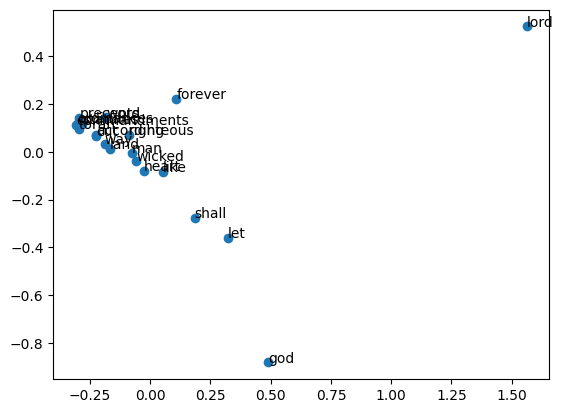

In [175]:
print("Plotting perceived Wisdom Psalm word-relatedness:\n")
plot_genre_pca(wisdom_most_common)

Zooming in the graph on perceived Wisdom Psalm word-relatedness:

lord (1.5627865263412792, 0.5228434136969938)
statutes (-0.2829647483318284, 0.11666650770016354)
word (-0.1831905028699972, 0.14330771493978833)
shall (0.18454551001231922, -0.27550163750345824)
torah (-0.2965845036783573, 0.09536899808510288)
commandments (-0.3083838923301426, 0.11113164005150601)
heart (-0.025387845311311164, -0.07979478854840993)
precepts (-0.29388806622785024, 0.14133819888338836)
wicked (-0.058166154251448, -0.039459217834751675)
according (-0.22371211379481715, 0.06995499191772167)
let (0.3221986153144848, -0.3609773250507632)
ordinances (-0.3016672641869037, 0.1215216462399537)
righteous (-0.0869870573309206, 0.07039713334849303)
like (0.05168730285629908, -0.0829728413861115)
man (-0.07652524637671348, -0.006140568124961332)
god (0.4880247048395958, -0.8801758567410957)
cut (-0.2242359683004944, 0.06637813803803799)
land (-0.1668686065808223, 0.012805769907177383)
way (-0.1888441508710444, 0.031

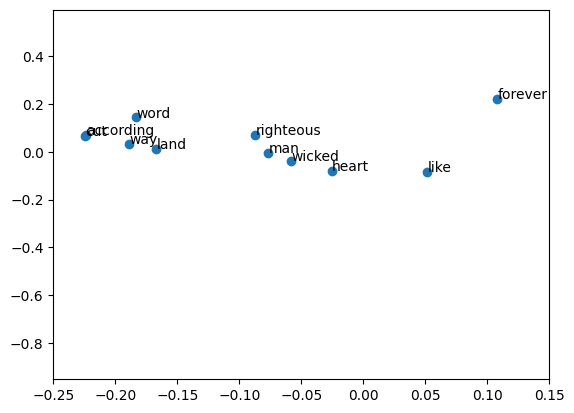

In [176]:
print("Zooming in the graph on perceived Wisdom Psalm word-relatedness:\n")
plot_genre_pca(wisdom_most_common, limit1=-0.25, limit2=0.15)

Plotting perceived Imprecatory Psalm word-relatedness:

let (0.21311235772144582, -0.3433780084321446)
god (0.3023801058924264, -0.8810551201014716)
lord (1.5681253841021723, 0.3524216477656733)
shall (0.08921512752878963, -0.23895604277548058)
like (-0.014508717154091522, -0.02928963014029387)
us (-0.00391815165867293, -0.20372829723797878)
sing (-0.04866252532473364, 0.07544381883805684)
soul (-0.004744523664028388, -0.027825328293409723)
strength (-0.16937928846983027, 0.09891484366976759)
also (-0.14063384767536577, 0.051478998364825446)
forever (0.0852405923615529, 0.2637414735079969)
hand (-0.12716957267514523, 0.03856280916516866)
kindness (0.020252491496593472, 0.15941309720922453)
among (-0.18240424050733284, 0.06012819707824868)
answer (-0.2838913479124862, 0.0990505772057026)
behold (-0.2586005672493226, 0.08130339953856464)
come (-0.1957827023987712, 0.0056237895810686556)
jerusalem (-0.27446103107790815, 0.21463526430852567)
know (-0.24408737612572606, 0.08922948170570225)

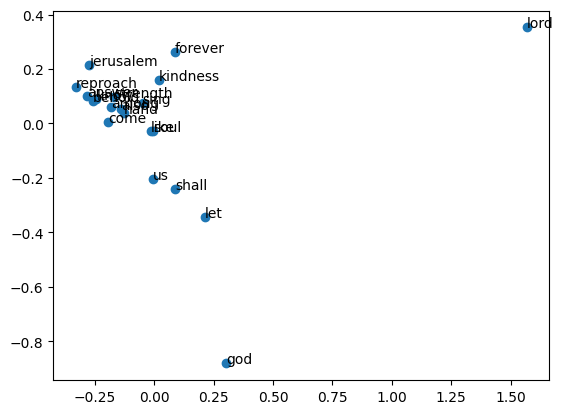

In [177]:
print("Plotting perceived Imprecatory Psalm word-relatedness:\n")
plot_genre_pca(imprecatory_most_common)

Zooming in the graph on perceived Imprecatory Psalm word-relatedness:

let (0.21311235772144582, -0.3433780084321446)
god (0.3023801058924264, -0.8810551201014716)
lord (1.5681253841021723, 0.3524216477656733)
shall (0.08921512752878963, -0.23895604277548058)
like (-0.014508717154091522, -0.02928963014029387)
us (-0.00391815165867293, -0.20372829723797878)
sing (-0.04866252532473364, 0.07544381883805684)
soul (-0.004744523664028388, -0.027825328293409723)
strength (-0.16937928846983027, 0.09891484366976759)
also (-0.14063384767536577, 0.051478998364825446)
forever (0.0852405923615529, 0.2637414735079969)
hand (-0.12716957267514523, 0.03856280916516866)
kindness (0.020252491496593472, 0.15941309720922453)
among (-0.18240424050733284, 0.06012819707824868)
answer (-0.2838913479124862, 0.0990505772057026)
behold (-0.2586005672493226, 0.08130339953856464)
come (-0.1957827023987712, 0.0056237895810686556)
jerusalem (-0.27446103107790815, 0.21463526430852567)
know (-0.24408737612572606, 0.089

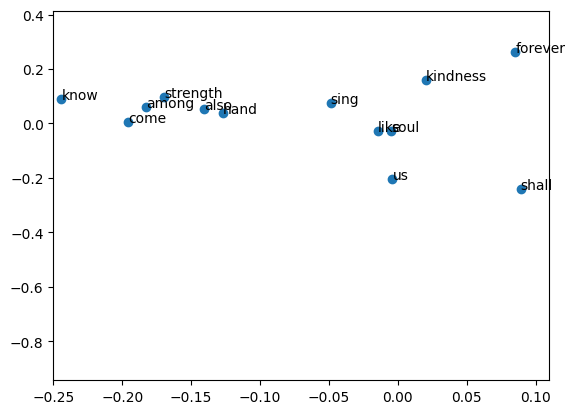

In [178]:
print("Zooming in the graph on perceived Imprecatory Psalm word-relatedness:\n")
plot_genre_pca(imprecatory_most_common, limit1=-0.25, limit2=0.11)

Plotting perceived Historical Psalm word-relatedness:

god (0.30424271987318663, -0.9710458243797373)
lord (1.6061034577237665, 0.22425106987766397)
also (-0.1108482425477611, -0.025751828801678645)
people (-0.04861185571453719, 0.01641685085078451)
israel (-0.12102867682210636, 0.06673736794083727)
land (-0.1858068094848739, 0.022006487258748292)
like (0.012819623664090507, -0.11023483754434832)
gave (-0.2709188303975515, 0.11233627094895185)
would (-0.2538322782573544, -0.044443155724171124)
anger (-0.23387074386928802, 0.08062046271791573)
let (0.23100124254408227, -0.4309522276066986)
children (-0.11689870470931968, 0.10977362154163675)
praise (0.4786854954895343, 0.43611456413971256)
turned (-0.2526038489843103, 0.0443835597457399)
fathers (-0.31020201218928545, 0.0864687751917006)
hand (-0.09777395870214645, -0.03906264194916112)
made (-0.07741226398963852, 0.10232517534548027)
nations (-0.05169632393204726, 0.059631211904474485)
sea (-0.21851015474064803, 0.11335349595781641)
se

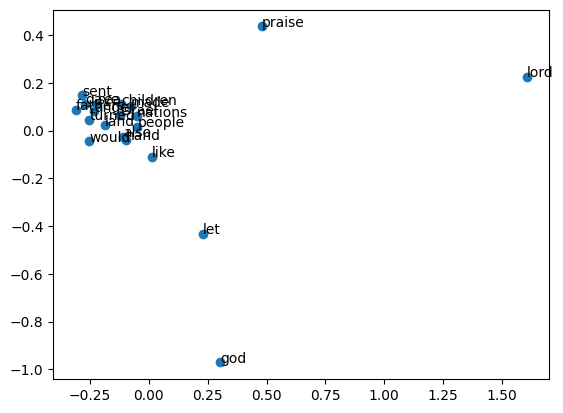

In [179]:
print("Plotting perceived Historical Psalm word-relatedness:\n")
plot_genre_pca(historical_most_common)

Zooming in the graph on perceived Historical Psalm word-relatedness:

god (0.30424271987318663, -0.9710458243797373)
lord (1.6061034577237665, 0.22425106987766397)
also (-0.1108482425477611, -0.025751828801678645)
people (-0.04861185571453719, 0.01641685085078451)
israel (-0.12102867682210636, 0.06673736794083727)
land (-0.1858068094848739, 0.022006487258748292)
like (0.012819623664090507, -0.11023483754434832)
gave (-0.2709188303975515, 0.11233627094895185)
would (-0.2538322782573544, -0.044443155724171124)
anger (-0.23387074386928802, 0.08062046271791573)
let (0.23100124254408227, -0.4309522276066986)
children (-0.11689870470931968, 0.10977362154163675)
praise (0.4786854954895343, 0.43611456413971256)
turned (-0.2526038489843103, 0.0443835597457399)
fathers (-0.31020201218928545, 0.0864687751917006)
hand (-0.09777395870214645, -0.03906264194916112)
made (-0.07741226398963852, 0.10232517534548027)
nations (-0.05169632393204726, 0.059631211904474485)
sea (-0.21851015474064803, 0.113353

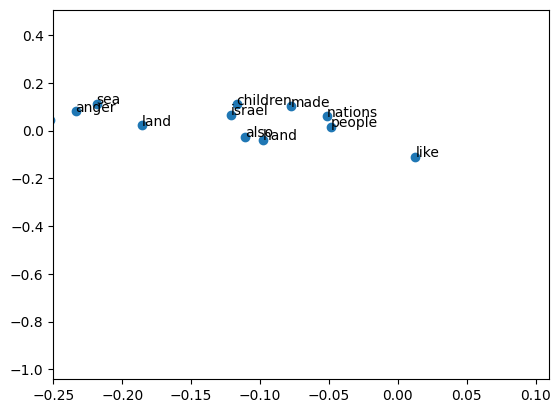

In [180]:
print("Zooming in the graph on perceived Historical Psalm word-relatedness:\n")
plot_genre_pca(historical_most_common, limit1=-0.25, limit2=0.11)

Plotting perceived Praise Psalm word-relatedness:

lord (1.546110201441744, 0.19605323066140382)
god (0.2411441129092135, -0.9958526187907887)
glory (-0.1520312621987583, 0.09250252998310704)
like (-0.04803845916996785, -0.1342863612886268)
praise (0.41924725161940807, 0.4108491665797005)
voice (-0.18445900315873287, 0.07715604824551442)
works (-0.1830305802497456, 0.17456315444195927)
earth (-0.0011649258494580983, -0.03606099526598097)
let (0.16930802357813374, -0.45557030041806545)
forever (0.06113341673468076, 0.15536628234792485)
king (-0.21942603635451685, 0.05705240970286267)
lift (-0.24300911392323615, 0.13137616566235708)
name (0.019131543541847706, 0.07332018459726547)
wicked (-0.14851613054909862, -0.07211357763435816)
enemies (-0.20766903373196463, -0.044799857968324586)
heavens (-0.16762648251496753, 0.1389124462435886)
holy (-0.13173868199938005, 0.06546935157154257)
judge (-0.2748203628752749, 0.047165807294348217)
kingdom (-0.33382142249748725, 0.1549802510031822)
man (

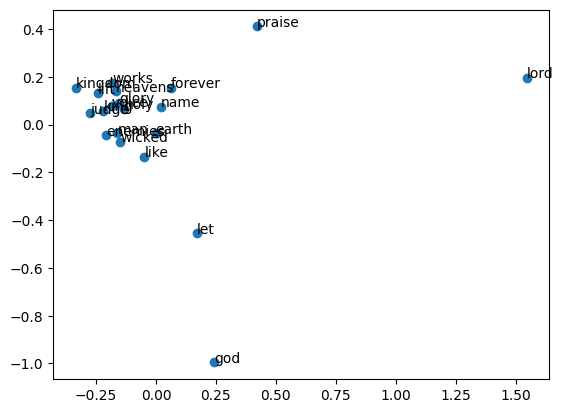

In [181]:
print("Plotting perceived Praise Psalm word-relatedness:\n")
plot_genre_pca(praise_most_common)

Zooming in the graph on perceived Praise Psalm word-relatedness:

lord (1.546110201441744, 0.19605323066140382)
god (0.2411441129092135, -0.9958526187907887)
glory (-0.1520312621987583, 0.09250252998310704)
like (-0.04803845916996785, -0.1342863612886268)
praise (0.41924725161940807, 0.4108491665797005)
voice (-0.18445900315873287, 0.07715604824551442)
works (-0.1830305802497456, 0.17456315444195927)
earth (-0.0011649258494580983, -0.03606099526598097)
let (0.16930802357813374, -0.45557030041806545)
forever (0.06113341673468076, 0.15536628234792485)
king (-0.21942603635451685, 0.05705240970286267)
lift (-0.24300911392323615, 0.13137616566235708)
name (0.019131543541847706, 0.07332018459726547)
wicked (-0.14851613054909862, -0.07211357763435816)
enemies (-0.20766903373196463, -0.044799857968324586)
heavens (-0.16762648251496753, 0.1389124462435886)
holy (-0.13173868199938005, 0.06546935157154257)
judge (-0.2748203628752749, 0.047165807294348217)
kingdom (-0.33382142249748725, 0.15498025

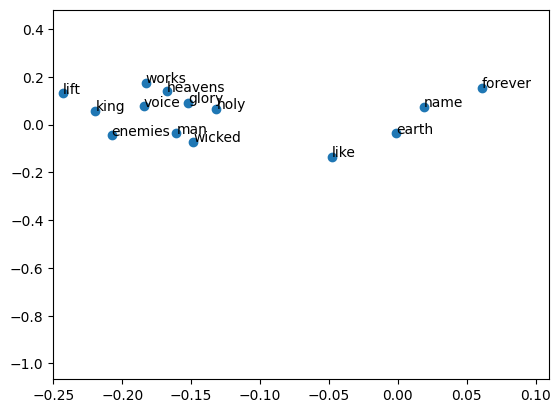

In [182]:
print("Zooming in the graph on perceived Praise Psalm word-relatedness:\n")
plot_genre_pca(praise_most_common, limit1=-0.25, limit2=0.11)

Plotting perceived Confidence Psalm word-relatedness:

lord (1.5618712749105599, 0.2207572027272903)
god (0.23622021898369883, -0.9480992145020644)
us (-0.035938019049258474, -0.256347712140133)
bless (-0.15639681181387627, 0.19718306740438804)
shall (0.05532368475562227, -0.29617362288295246)
soul (-0.027996007544719315, -0.08062218232881896)
let (0.17386232493758147, -0.40664109024246775)
peoples (-0.1666355767046603, 0.10100212971384634)
alone (-0.3420940991940746, 0.12317179899019738)
earth (0.010766454229709621, 0.01579094044858692)
praise (0.4389451250515639, 0.45526576063545127)
salvation (-0.19601495701383417, 0.013496928823570759)
heavens (-0.15260355056526306, 0.19365436168661995)
help (-0.2175165362418571, 0.03793134994616382)
house (-0.134046118922732, 0.21785622109492192)
nations (-0.09890557637021175, 0.08953196145449856)
righteous (-0.1442402356711865, 0.09568111610687269)
rock (-0.29739597022569014, 0.06332647701038725)
shield (-0.27903271499029, 0.1382909343270383)
tak

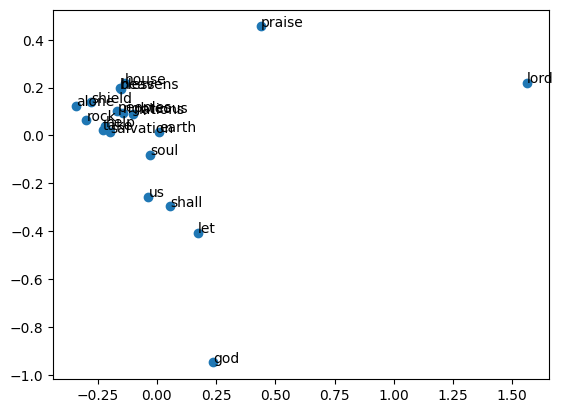

In [183]:
print("Plotting perceived Confidence Psalm word-relatedness:\n")
plot_genre_pca(confidence_most_common)

Zooming in the graph on perceived Confidence Psalm word-relatedness:

lord (1.5618712749105599, 0.2207572027272903)
god (0.23622021898369883, -0.9480992145020644)
us (-0.035938019049258474, -0.256347712140133)
bless (-0.15639681181387627, 0.19718306740438804)
shall (0.05532368475562227, -0.29617362288295246)
soul (-0.027996007544719315, -0.08062218232881896)
let (0.17386232493758147, -0.40664109024246775)
peoples (-0.1666355767046603, 0.10100212971384634)
alone (-0.3420940991940746, 0.12317179899019738)
earth (0.010766454229709621, 0.01579094044858692)
praise (0.4389451250515639, 0.45526576063545127)
salvation (-0.19601495701383417, 0.013496928823570759)
heavens (-0.15260355056526306, 0.19365436168661995)
help (-0.2175165362418571, 0.03793134994616382)
house (-0.134046118922732, 0.21785622109492192)
nations (-0.09890557637021175, 0.08953196145449856)
righteous (-0.1442402356711865, 0.09568111610687269)
rock (-0.29739597022569014, 0.06332647701038725)
shield (-0.27903271499029, 0.138290

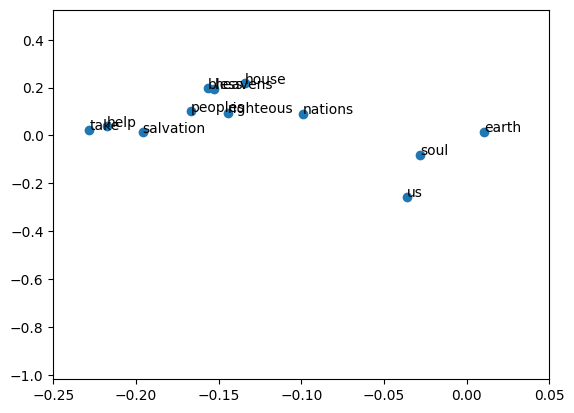

In [184]:
print("Zooming in the graph on perceived Confidence Psalm word-relatedness:\n")
plot_genre_pca(confidence_most_common, limit1=-0.25, limit2=0.05)

Part Six:
Cosine simliarities will be computed between words in each given genre corpus and the words "lord" and "god".

Something interesting I noticed is that the words "lord" and "god" are almost always the most common words used in a group of Psalms associated with a given genre. I assume these words are primarily references to God Himself, His name and titles often translated as either "Lord" or "God".

The word "praise" is also usually far from the other points, and is the nearest word to "lord" across genres where both of these words are seen as among the most commonly occuring words in a genre.

These thoughts can be confirmed or found otherwise through examining the Psalms that contain these words within them.

Out of curiosity, I will be using what scores cosine similarity computes for each word pair in a given Psalm genre containing the words "lord" or "god".

In [ ]:
# Compute cosine similarities between a target word and each word in a Psalm genre's chosen representative words.
def similarity(target_word, genre_rep_words):
        # Initialize list to hold similarity scores:
    sims = []
        # Iterate through the genre's representative words:
    for word, count in genre_rep_words:
        if word != target_word:
            # Compute cosine similarity between the target_word embedding and current word iteration:
            cos_sim = cosine_similarity(psalms_vocab_map[target_word].reshape(1, -1), psalms_vocab_map[word].reshape(1, -1))
            # print(cos_sim[0])
            
                # Update list with (word being compared to the target word, cosine similairty between target word and current iteration word):
            sim_pair = (word, cos_sim[0])
            sims.append(sim_pair)
            # print()

        # Final output, sorted in descending order by second element:
    sims = sorted(sims , key=lambda x:(-x[1], x[0]))    # Source for this line of code listed in the cell defining the find_genre_most_common_words() function:
    return sims[:10]

In [ ]:
# Function for displaying cosine similarity between a target word and each word representative of a Psalm genre.

def display_cosine_similarity(target_word, genre_most_common, genre):
    genre_word_similarity = similarity(target_word, genre_most_common)
    
    print(f"Words with highest cosine similarities to: '{target_word}' in Psalm genre '{genre}':\n")
    
    for word in genre_word_similarity:
        print(word)

The following cells will compute cosine similarities between "lord" and words appearing in one Psalm genre at a time. 

They will also compute cosine similarities between "god" and words appearing in one Psalm genre at a time.

In [149]:
display_cosine_similarity("lord", lament_most_common, "lament")
print()
display_cosine_similarity("god", lament_most_common, "lament")

Words with highest cosine similarities to: 'lord' in Psalm genre 'lament':

('operation', array([0.9999985]))
('lift', array([0.99996849]))
('heavens', array([0.99989573]))
('word', array([0.99984483]))
('answered', array([0.99976977]))
('forever', array([0.99968541]))
('gods', array([0.99927077]))
('sins', array([0.99685936]))
('petitions', array([0.98897533]))
('flattering', array([0.98808685]))

Words with highest cosine similarities to: 'god' in Psalm genre 'lament':

('shoot', array([0.99999192]))
('surely', array([0.99995817]))
('eat', array([0.99995396]))
('mute', array([0.99990009]))
('sin', array([0.99986923]))
('deceitful', array([0.99976978]))
('suddenly', array([0.99976546]))
('weak', array([0.99973932]))
('pain', array([0.99964367]))
('rescue', array([0.9993807]))


In [150]:
display_cosine_similarity("lord", thanksgiving_most_common, "thanksgiving")
print()
display_cosine_similarity("god", thanksgiving_most_common, "thanksgiving")

Words with highest cosine similarities to: 'lord' in Psalm genre 'thanksgiving':

('lands', array([0.99999337]))
('princes', array([0.99998867]))
('wonderful', array([0.99996019]))
('heavens', array([0.99989573]))
('mighty', array([0.99989145]))
('word', array([0.99984483]))
('rejoicing', array([0.99983568]))
('whole', array([0.99977755]))
('forever', array([0.99968541]))
('time', array([0.9987385]))

Words with highest cosine similarities to: 'god' in Psalm genre 'thanksgiving':

('roaring', array([0.99999497]))
('oh', array([0.99990821]))
('sin', array([0.99986923]))
('selah', array([0.99898105]))
('grain', array([0.99823404]))
('overflow', array([0.99738802]))
('water', array([0.99449722]))
('iniquity', array([0.99120867]))
('come', array([0.98596437]))
('us', array([0.98467809]))


In [151]:
display_cosine_similarity("lord", enthronement_most_common, "enthronement")
print()
display_cosine_similarity("god", enthronement_most_common, "enthronement")

Words with highest cosine similarities to: 'lord' in Psalm genre 'enthronement':

('justice', array([0.99998681]))
('exalt', array([0.99997344]))
('mighty', array([0.99989145]))
('lifted', array([0.999687]))
('reigns', array([0.99965999]))
('gods', array([0.99927077]))
('name', array([0.98741372]))
('armed', array([0.98654547]))
('glory', array([0.98615221]))
('great', array([0.98020354]))

Words with highest cosine similarities to: 'god' in Psalm genre 'enthronement':

('us', array([0.98467809]))
('let', array([0.96703108]))
('shout', array([0.96198777]))
('among', array([0.94034485]))
('salvation', array([0.93859428]))
('glad', array([0.91501242]))
('noise', array([0.90250286]))
('make', array([0.89078438]))
('righteousness', array([0.88095198]))
('strength', array([0.8760948]))


In [152]:
display_cosine_similarity("lord", pilgrimage_most_common, "pilgrimage")
print()
display_cosine_similarity("god", pilgrimage_most_common, "pilgrimage")

Words with highest cosine similarities to: 'lord' in Psalm genre 'pilgrimage':

('lift', array([0.99996849]))
('loves', array([0.99986227]))
('stand', array([0.99980245]))
('forever', array([0.99968541]))
('pleasant', array([0.99897081]))
('fears', array([0.99767096]))
('everyone', array([0.99632632]))
('comes', array([0.99628276]))
('concern', array([0.99600299]))
('weaned', array([0.99600299]))

Words with highest cosine similarities to: 'god' in Psalm genre 'pilgrimage':

('eat', array([0.99995396]))
('oh', array([0.99990821]))
('city', array([0.99990379]))
('hosts', array([0.99899669]))
('selah', array([0.99898105]))
('born', array([0.9982995]))
('would', array([0.99794479]))
('cause', array([0.99743461]))
('judah', array([0.99450072]))
('lofty', array([0.99445401]))


In [153]:
display_cosine_similarity("lord", royal_most_common, "royal")
print()
display_cosine_similarity("god", royal_most_common, "royal")

Words with highest cosine similarities to: 'lord' in Psalm genre 'royal':

('faithfulness', array([0.99994158]))
('mighty', array([0.99989145]))
('forever', array([0.99968541]))
('house', array([0.99462569]))
('name', array([0.98741372]))
('hands', array([0.98536507]))
('resting', array([0.98530639]))
('loving', array([0.98436143]))
('kings', array([0.98187149]))
('made', array([0.97807367]))

Words with highest cosine similarities to: 'god' in Psalm genre 'royal':

('bring', array([0.99967097]))
('rescue', array([0.9993807]))
('one', array([0.99169647]))
('within', array([0.9905104]))
('dwelling', array([0.989696]))
('answer', array([0.98966664]))
('rock', array([0.9852147]))
('go', array([0.98312956]))
('shall', array([0.97031958]))
('let', array([0.96703108]))


In [154]:
display_cosine_similarity("lord", wisdom_most_common, "wisdom")
print()
display_cosine_similarity("god", wisdom_most_common, "wisdom")

Words with highest cosine similarities to: 'lord' in Psalm genre 'wisdom':

('ordinances', array([0.99992312]))
('word', array([0.99984483]))
('stand', array([0.99980245]))
('forever', array([0.99968541]))
('statutes', array([0.99325916]))
('commandments', array([0.98266707]))
('blessed', array([0.97953546]))
('understanding', array([0.97636982]))
('upright', array([0.97097675]))
('precepts', array([0.96056824]))

Words with highest cosine similarities to: 'god' in Psalm genre 'wisdom':

('surely', array([0.99995817]))
('rich', array([0.99668982]))
('behold', array([0.98285579]))
('inherit', array([0.98188539]))
('wealth', array([0.97453136]))
('shall', array([0.97031958]))
('let', array([0.96703108]))
('plagued', array([0.96121697]))
('afraid', array([0.94787965]))
('heart', array([0.94245595]))


In [155]:
display_cosine_similarity("lord", imprecatory_most_common, "imprecatory")
print()
display_cosine_similarity("god", imprecatory_most_common, "imprecatory")

Words with highest cosine similarities to: 'lord' in Psalm genre 'imprecatory':

('princes', array([0.99998867]))
('forever', array([0.99968541]))
('jerusalem', array([0.99346153]))
('name', array([0.98741372]))
('loving', array([0.98436143]))
('children', array([0.97858564]))
('kindness', array([0.97690271]))
('zion', array([0.97043076]))
('voice', array([0.96880517]))
('holy', array([0.96866016]))

Words with highest cosine similarities to: 'god' in Psalm genre 'imprecatory':

('songs', array([0.99998684]))
('reproach', array([0.99976342]))
('bring', array([0.99967097]))
('search', array([0.99962218]))
('babylon', array([0.99953294]))
('selah', array([0.99898105]))
('contend', array([0.99892012]))
('deep', array([0.99881323]))
('would', array([0.99794479]))
('enemy', array([0.99769687]))


In [156]:
display_cosine_similarity("lord", historical_most_common, "historical")
print()
display_cosine_similarity("god", historical_most_common, "historical")

Words with highest cosine similarities to: 'lord' in Psalm genre 'historical':

('word', array([0.99984483]))
('moon', array([0.99711544]))
('sent', array([0.99691245]))
('works', array([0.98543198]))
('loving', array([0.98436143]))
('great', array([0.98020354]))
('blessed', array([0.97953546]))
('children', array([0.97858564]))
('made', array([0.97807367]))
('praise', array([0.95705736]))

Words with highest cosine similarities to: 'god' in Psalm genre 'historical':

('oh', array([0.99990821]))
('fathers', array([0.99892478]))
('would', array([0.99794479]))
('listen', array([0.98867972]))
('come', array([0.98596437]))
('turned', array([0.9751999]))
('shall', array([0.97031958]))
('let', array([0.96703108]))
('shout', array([0.96198777]))
('jacob', array([0.95767233]))


In [159]:
display_cosine_similarity("lord", praise_most_common, "wisdom")
print()
display_cosine_similarity("god", praise_most_common, "wisdom")

Words with highest cosine similarities to: 'lord' in Psalm genre 'wisdom':

('lift', array([0.99996849]))
('heavens', array([0.99989573]))
('lifted', array([0.999687]))
('forever', array([0.99968541]))
('ever', array([0.99960007]))
('horn', array([0.99856542]))
('execute', array([0.99723245]))
('thanks', array([0.99540647]))
('majestic', array([0.99516004]))
('gates', array([0.99010522]))

Words with highest cosine similarities to: 'god' in Psalm genre 'wisdom':

('skipped', array([0.99999381]))
('selah', array([0.99898105]))
('drink', array([0.99813162]))
('calls', array([0.9970791]))
('rams', array([0.99617594]))
('blamelessly', array([0.99191906]))
('one', array([0.99169647]))
('silent', array([0.98851002]))
('behold', array([0.98285579]))
('heads', array([0.98116761]))


In [160]:
display_cosine_similarity("lord", confidence_most_common, "confidence")
print()
display_cosine_similarity("god", confidence_most_common, "confidence")

Words with highest cosine similarities to: 'lord' in Psalm genre 'confidence':

('heavens', array([0.99989573]))
('loves', array([0.99986227]))
('bless', array([0.99956155]))
('house', array([0.99462569]))
('lack', array([0.99343243]))
('makes', array([0.98945782]))
('upright', array([0.97097675]))
('holy', array([0.96866016]))
('praise', array([0.95705736]))
('nations', array([0.94589179]))

Words with highest cosine similarities to: 'god' in Psalm genre 'confidence':

('shaken', array([0.99997509]))
('selah', array([0.99898105]))
('lie', array([0.99723197]))
('fortress', array([0.99670254]))
('refuge', array([0.99005172]))
('rock', array([0.9852147]))
('us', array([0.98467809]))
('alone', array([0.97846041]))
('shall', array([0.97031958]))
('let', array([0.96703108]))


Part Seven:
Analysis and Thoughts

The reason why I thought it was cool that "Lord" and "God" are consistently shown as outliers among the word-relatedness graphs is because I am wondering if the Psalms poetry structure uses God's name in such a unique way compared to the rest of the vocabulary, and if so is the model able to detect that?

This is something I would like to look into, and am curious if this is an artistic choice of God through the psalmists to communicate His attribute of holiness.

If I were to continue moving further with this project, I would be curious about learning more about topic modelling and how to accurately represent texts with it, especially if it is God's Word. 

Another thing that I am curious about is how embeddings perform on the original language or different translations, and how they can be used for Bible study, dictionary, or translation tools.